In this notebook,
- convert to daily data
- Use VG's strategy - to predict lowest borrow rate for a given time
- Start with basic models 

# Install Libraries and imports

In [37]:
!pip install fastai -Uqq
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz -Uqq

In [38]:
from fastai.tabular.all import *
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import r2_score
from torch.utils.data import Dataset
from dtreeviz.trees import *

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [39]:
RANDOM_STATE = 42

# Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
path = Path('/content/drive/MyDrive/colab_notebooks/algovera/defi')

# Preparing the data

In [42]:
df = pd.read_csv(path/'compound.csv')
df["Date"] = pd.to_datetime(df["Timestamp"], unit='s', origin='unix')

tokens = df["Token"].unique()
tokens

array(['DAI', 'USDC', 'USDT', 'ETH'], dtype=object)

In [43]:
df = df.drop_duplicates(['Timestamp', 'Token'])
counts = pd.DataFrame(df['Timestamp'].value_counts()).reset_index()
counts.columns = ['Timestamp', 'Counts']
df = df.merge(counts, on='Timestamp')

In [44]:
df = df[df['Counts'] == 4].reset_index(drop=True).drop('Counts', axis=1)

In [55]:
df["Date"].min(),df["Date"].max()

(Timestamp('2021-01-01 03:30:00'), Timestamp('2021-12-14 18:30:00'))

In [45]:
df1 = pd.DataFrame()
for tok in tokens:
    df_tok = df[df['Token']==tok]
    df_tok = df_tok.drop(['Token', 'Date'], axis=1)

    col_names = []
    for col in df_tok.columns:
        if col == 'Timestamp':
            col_names.append(f'{col}')
        else:
            col_names.append(f'{tok}_{col}')
        
    df_tok.columns = col_names
    #df_tok = df_tok.set_index('Timestamp', drop=True)
    
    if df1.empty:
        df1 = df_tok
    else:
        df1 = pd.merge(df1, df_tok, on='Timestamp')

In [46]:
df1.sort_values('Timestamp', inplace=True)
df1["Date"] = pd.to_datetime(df1["Timestamp"], unit='s', origin='unix')

In [47]:
df1.head()

,Timestamp,DAI_Borrowing Rate,DAI_Deposit Rate,DAI_Borrow Volume,DAI_Supply Volume,USDC_Borrowing Rate,USDC_Deposit Rate,USDC_Borrow Volume,USDC_Supply Volume,USDT_Borrowing Rate,USDT_Deposit Rate,USDT_Borrow Volume,USDT_Supply Volume,ETH_Borrowing Rate,ETH_Deposit Rate,ETH_Borrow Volume,ETH_Supply Volume,Date
0,1609471800,0.073195,0.050982,1.069964e+09,6.196481e+10,0.087046,0.066993,7.285430e+08,4.063042e+10,0.099588,0.077548,6.430536e+07,3.696225e+09,0.022952,0.000489,30553.654354,5.663257e+07,2021-01-01 03:30:00
1,1609473600,0.073101,0.050912,1.069961e+09,6.197050e+10,0.087053,0.066998,7.285469e+08,4.063019e+10,0.094890,0.073569,6.407877e+07,3.700299e+09,0.022952,0.000489,30553.703955,5.663353e+07,2021-01-01 04:00:00
2,1609475400,0.073061,0.050882,1.069972e+09,6.197354e+10,0.087058,0.067003,7.285528e+08,4.063019e+10,0.085767,0.065933,6.399418e+07,3.729213e+09,0.022951,0.000489,30553.830472,5.664534e+07,2021-01-01 04:30:00
3,1609477200,0.073436,0.051161,1.070496e+09,6.197966e+10,0.086921,0.066889,7.285713e+08,4.063660e+10,0.072946,0.055500,6.317162e+07,3.730028e+09,0.022952,0.000489,30553.786270,5.663860e+07,2021-01-01 05:00:00
4,1609479000,0.067829,0.047015,1.070566e+09,6.234580e+10,0.086312,0.066383,7.285755e+08,4.066162e+10,0.057764,0.043239,6.256095e+07,3.752927e+09,0.022952,0.000489,30553.841412,5.663440e+07,2021-01-01 05:30:00


In [48]:
# resample to daily data - here using the mean value 
df1 = df1.resample('D', on='Date').mean().reset_index()

In [49]:
df1.head(5)

,Date,Timestamp,DAI_Borrowing Rate,DAI_Deposit Rate,DAI_Borrow Volume,DAI_Supply Volume,USDC_Borrowing Rate,USDC_Deposit Rate,USDC_Borrow Volume,USDC_Supply Volume,USDT_Borrowing Rate,USDT_Deposit Rate,USDT_Borrow Volume,USDT_Supply Volume,ETH_Borrowing Rate,ETH_Deposit Rate,ETH_Borrow Volume,ETH_Supply Volume
0,2021-01-01,1.609508e+09,0.067015,0.046416,1.069840e+09,6.235339e+10,0.067119,0.050751,7.287942e+08,4.148543e+10,0.041173,0.026994,6.347122e+07,4.691459e+09,0.022941,0.000487,30523.713818,5.679480e+07
1,2021-01-02,1.609589e+09,0.065503,0.045303,1.065628e+09,6.219795e+10,0.069537,0.052642,7.325264e+08,4.158170e+10,0.034604,0.021670,7.173786e+07,5.154309e+09,0.023000,0.000499,31171.739844,5.677785e+07
2,2021-01-03,1.609675e+09,0.082682,0.058162,1.008454e+09,5.784234e+10,0.077396,0.059038,7.383219e+08,4.156605e+10,0.064975,0.049139,7.490249e+07,4.573581e+09,0.022966,0.000492,30862.373557,5.691729e+07
3,2021-01-04,1.609761e+09,0.083715,0.058879,9.983436e+08,5.717052e+10,0.080040,0.061212,7.588534e+08,4.259876e+10,0.078345,0.059959,7.566239e+07,4.441844e+09,0.022258,0.000355,22981.846369,5.698653e+07
4,2021-01-05,1.609847e+09,0.081061,0.056868,9.989683e+08,5.734897e+10,0.070036,0.053091,7.487804e+08,4.245228e+10,0.088893,0.068642,7.785167e+07,4.520668e+09,0.023610,0.000626,37120.356644,5.562969e+07


In [50]:
df1 = df1.iloc[:, :]

In [51]:
# check if there r missing dates
daydiff = (df1['Date'].shift(-1) - df1['Date']).apply(lambda x: x.days)

In [52]:
daydiff.value_counts()

1.0    347
Name: Date, dtype: int64

# Understanding the data

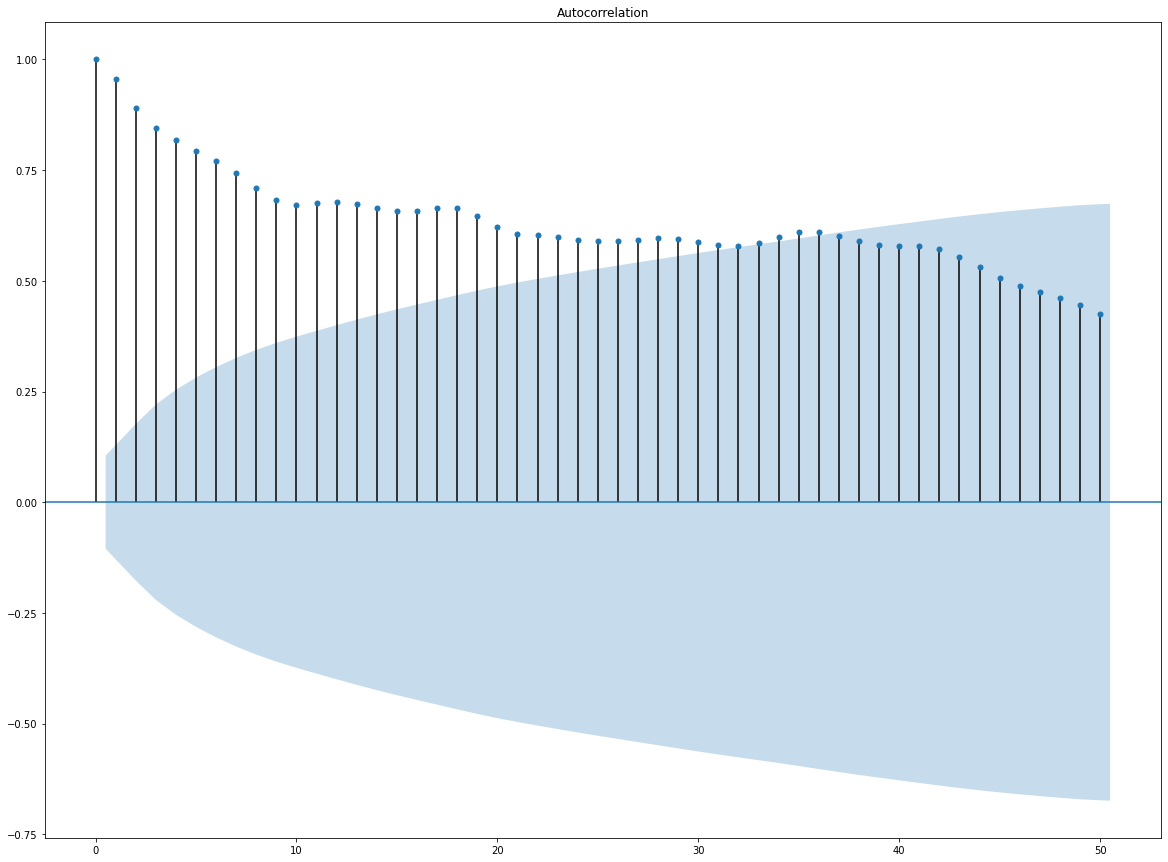

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_acf(df1['DAI_Borrowing Rate'], ax=ax, lags=50)
print()

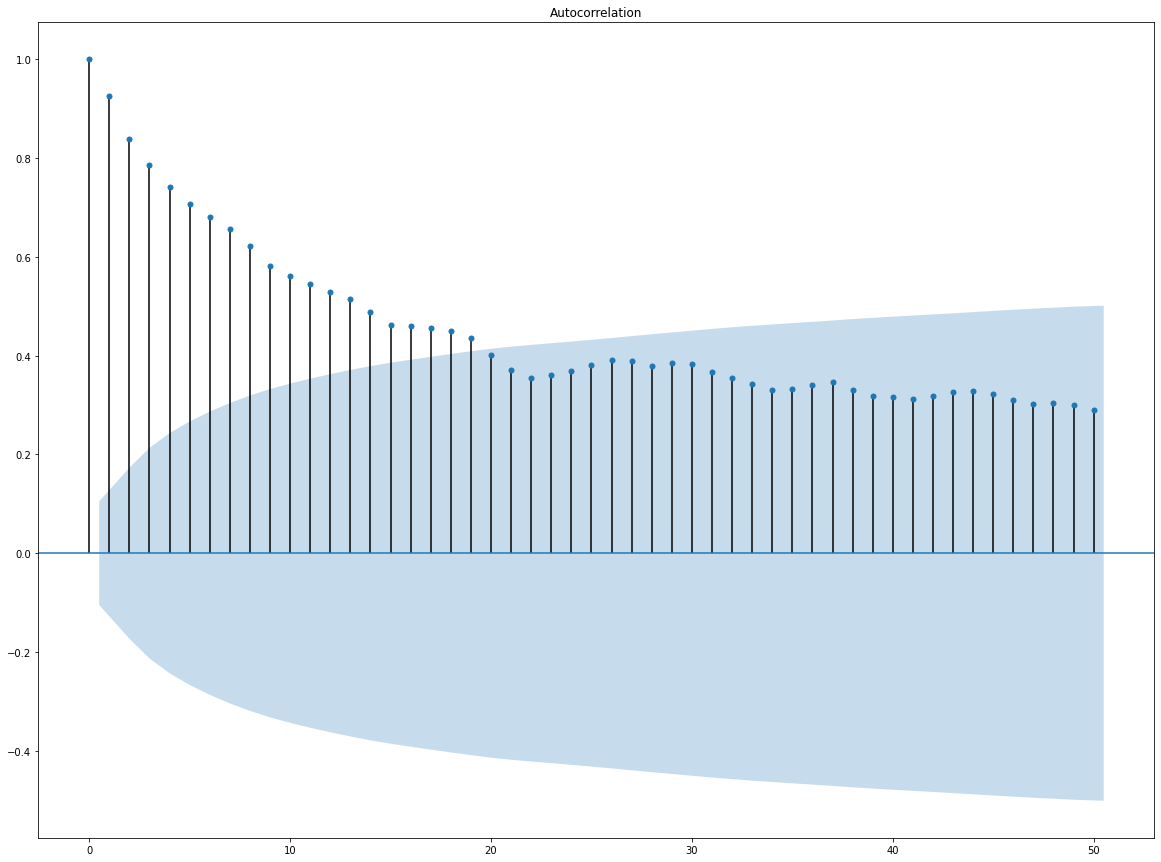

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_acf(df1['USDC_Borrowing Rate'], ax=ax, lags=50)
print()

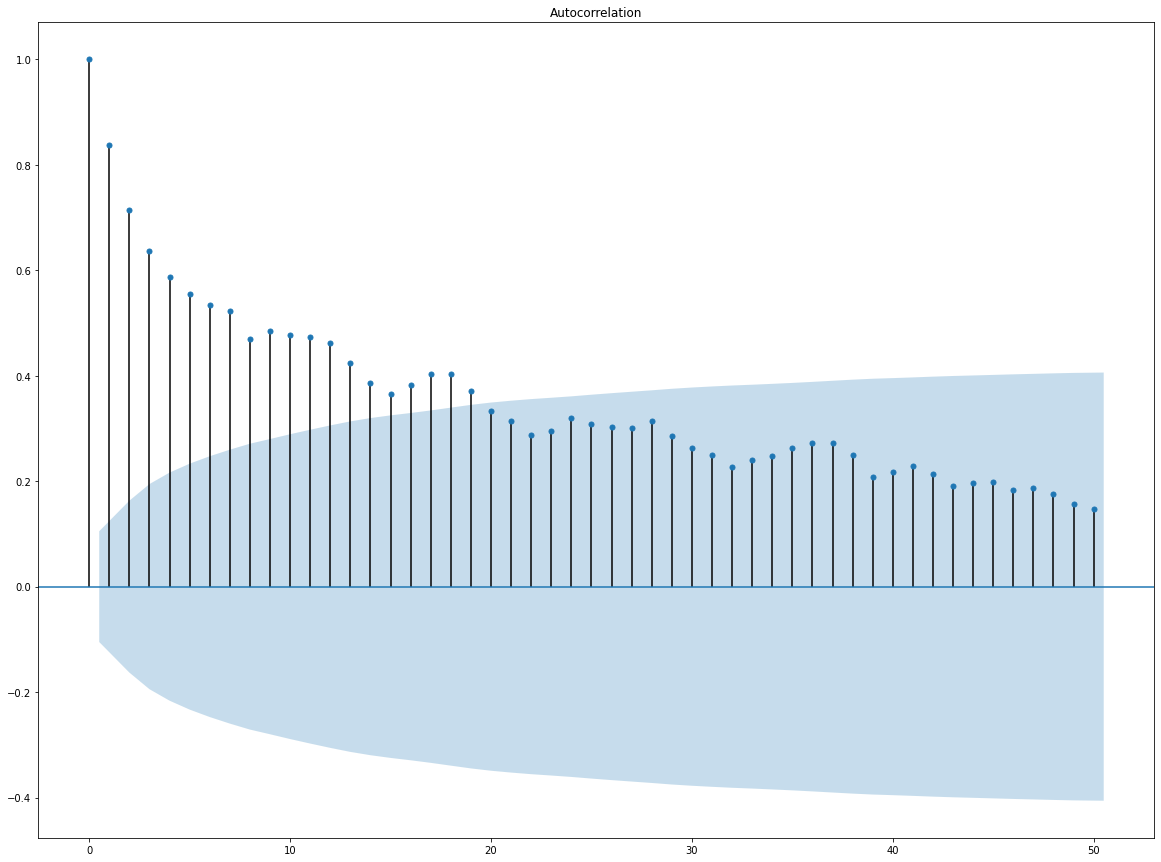

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_acf(df1['USDT_Borrowing Rate'], ax=ax, lags=50)
print()

# Prepare df 

In [ ]:
def get_synth_sample(x,y):

    from imblearn.combine import SMOTETomek,SMOTEENN
    X_resampled, y_resampled = SMOTETomek().fit_resample(x, y)

    synthetic_samples = y.shape[0] - y_resampled.shape[0]

    synthetic_indices = y[synthetic_samples:]

    return X_resampled,y_resampled



def get_tabpandas_multi(
    df:pd.DataFrame, # Dataframe of the raw data 
    n_timepoint:int, # Number of previous timepoints to be used as features   
    target_window:int, # Number of timepoints in the future to predict 
    stratify_sample:bool=False, #Make test train split stratified by class
    filter_cols:list=None,
    inference:bool=False, # Flag True for inference
    synth_sample:bool=False
):

    df = df.reset_index(drop=True)
    feature_cols = ['DAI_Borrowing Rate', 'DAI_Deposit Rate', 'DAI_Borrow Volume', 'DAI_Supply Volume', 
                    'USDC_Borrowing Rate', 'USDC_Deposit Rate', 'USDC_Borrow Volume', 'USDC_Supply Volume', 
                    'USDT_Borrowing Rate', 'USDT_Deposit Rate', 'USDT_Borrow Volume', 'USDT_Supply Volume',
                    'ETH_Borrowing Rate', 'ETH_Deposit Rate', 'ETH_Borrow Volume', 'ETH_Supply Volume'
                    ]

    target_columns = ['DAI_Borrowing Rate', 'USDC_Borrowing Rate', 'USDT_Borrowing Rate']
    target = 'Target'

    cols_names = []
    for j in range(n_timepoint):
        for col in feature_cols:
            cols_names.append(f'{col}_t-{n_timepoint -j-1}')
    cols_names += [target]

    pairs = []
    for i, row in tqdm(df.iterrows()):
        if i < (len(df)-target_window-n_timepoint-1):
            features = df.loc[i:i+n_timepoint-1, feature_cols].values
            features = [item for sublist in features for item in sublist]

            val =  df.loc[i+n_timepoint: i+n_timepoint-1+target_window, target_columns].mean().idxmin()

            features += [val]

            pairs.append(features)

    df = pd.DataFrame(pairs, columns=cols_names).dropna().reset_index(drop=True)

    
    if not inference:
        if filter_cols:
            x = df.iloc[:,filter_cols]
            y = df.iloc[:, -1]
        else:
            x = df.iloc[:, :-1]
            y = df.iloc[:, -1]

        if synth_sample:
            x,y = get_synth_sample(x,y)

        if stratify_sample:
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                                random_state=RANDOM_STATE,
                                                                shuffle=True,stratify=y)
        else:
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True)


        ss = StandardScaler()
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)

        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)

        return df,x_train, x_test, y_train, y_test, ss, le #synthetic_indices

    if inference:
        return df


def plot_confusion_matrix(
    preds,
    targs,
    title
):
    cm = confusion_matrix(targs, preds, normalize=None)
    df_cm = pd.DataFrame(cm, 
                         columns=['DAI', 'USDC', 'USDT'], 
                         index=['DAI', 'USDC', 'USDT'])
    
    ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 16},
            cmap="Blues",
            ).set_title(title)
            
    plt.show()

In [ ]:
df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7)

348it [00:00, 514.02it/s]


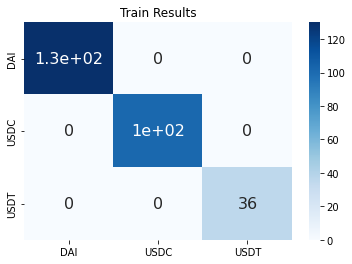

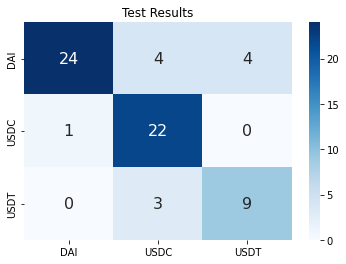

(None, None)

In [ ]:
clf = RandomForestClassifier(n_estimators=90, random_state=RANDOM_STATE)
clf.fit(x_train, y_train)

train_preds = clf.predict(x_train)
preds = clf.predict(x_test)

plot_confusion_matrix(y_train, train_preds,"Train Results"),plot_confusion_matrix(y_test, preds,"Test Results")

In [ ]:
from sklearn.manifold import TSNE
def tsne_plot(x,y,title):



    n_components = np.unique(y_test).shape[0]

    tsne_result = TSNE(n_components=n_components, learning_rate='auto',
                init='random').fit_transform(x_train)

    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1],'tsne_3': tsne_result[:,2], 'label': y_train})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    _ = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    ax.set_title(title)

## TSNE 
This shows how much overlap there is between classes with the feature space

348it [00:00, 573.67it/s]
348it [00:00, 593.29it/s]
348it [00:00, 587.23it/s]


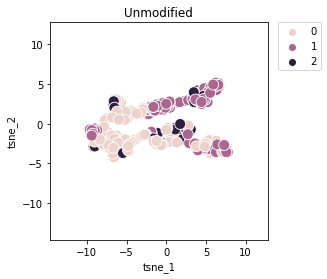

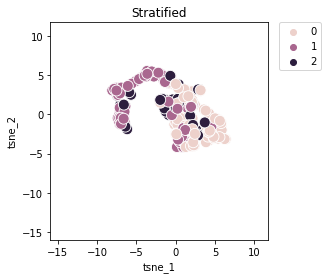

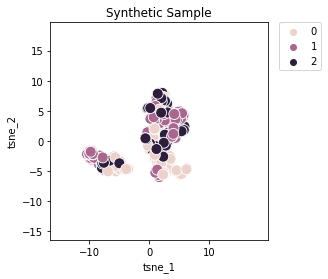

In [ ]:
df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=False)

tsne_plot(x_train,y_train,"Unmodified")

df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=True)
tsne_plot(x_train,y_train,"Stratified")

df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,synth_sample=True)
tsne_plot(x_train,y_train,"Synthetic Sample")




In [ ]:
np.unique(y_train,return_counts=True),np.unique(y_test,return_counts=True)

((array([0, 1, 2]), array([116, 125, 123])),
 (array([0, 1, 2]), array([35, 25, 31])))

# Basic Model

## Decision Tree & Random Forest

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from pandas.core.common import random_state
from sklearn.model_selection import GridSearchCV

classifier_params = {
                    "DecisionTreeClassifier":{"random_state":[RANDOM_STATE]},
                     
                    "RandomForestClassifier":{"n_estimators":range(10,250, 10),
                                              "random_state":[RANDOM_STATE],
                                            "min_samples_leaf":[1,3,6,9,12],
                                            "max_depth":[3,6,9,12]
                                            },
                     
                    "AdaBoostClassifier":{"n_estimators":range(30,250, 10),
                                          "random_state":[RANDOM_STATE]},
                     
                    "GradientBoostingClassifier":{"n_estimators":range(30,250, 10), 
                                                    "learning_rate":[0.05,0.1,0.5],
                                                  "random_state":[RANDOM_STATE]
                                                    }
                        }

348it [00:00, 575.74it/s]
348it [00:00, 586.41it/s]


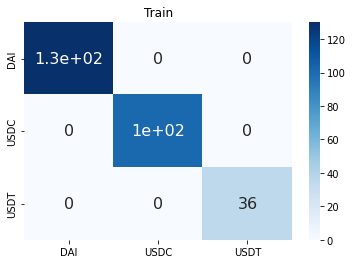

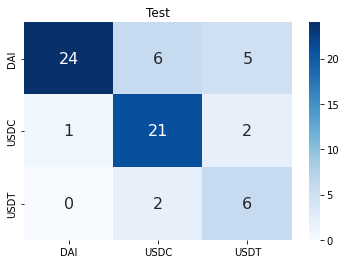

(None, None)

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=False)

clf = RandomForestClassifier(n_estimators=90,random_state=42)
clf = clf.fit(x_train, y_train)
preds = clf.predict(x_test)

fi = rf_feat_importance(clf, pd.DataFrame(x_test))

top20features = list(fi[:20].cols)

top20features

df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=False,filter_cols=top20features)

clf = RandomForestClassifier(n_estimators=150,random_state=42)
clf = clf.fit(x_train, y_train)

train_preds = clf.predict(x_train)
test_preds = clf.predict(x_test)
plot_confusion_matrix(y_train, train_preds,"Train"),plot_confusion_matrix(y_test, test_preds,"Test")

In [ ]:
# Interesting that Eth features didn't help

df.iloc[:,top20features]

,USDC_Borrowing Rate_t-0,USDC_Deposit Rate_t-0,USDC_Borrowing Rate_t-2,USDC_Deposit Rate_t-1,USDC_Deposit Rate_t-3,USDC_Borrowing Rate_t-3,USDC_Borrowing Rate_t-1,USDC_Deposit Rate_t-4,ETH_Borrow Volume_t-4,USDC_Borrowing Rate_t-4,USDT_Borrow Volume_t-3,ETH_Supply Volume_t-4,USDC_Borrow Volume_t-4,USDT_Borrow Volume_t-1,USDC_Borrow Volume_t-3,ETH_Supply Volume_t-2,USDC_Deposit Rate_t-2,DAI_Supply Volume_t-3,USDT_Deposit Rate_t-3,USDC_Borrow Volume_t-2
0,0.070036,0.053091,0.077396,0.061212,0.052642,0.069537,0.080040,0.050751,30523.713818,0.067119,7.173786e+07,5.679480e+07,7.287942e+08,7.566239e+07,7.325264e+08,5.691729e+07,0.059038,6.219795e+10,0.021670,7.383219e+08
1,0.110526,0.087139,0.080040,0.053091,0.059038,0.077396,0.070036,0.052642,31171.739844,0.069537,7.490249e+07,5.677785e+07,7.325264e+08,7.785167e+07,7.383219e+08,5.698653e+07,0.061212,5.784234e+10,0.049139,7.588534e+08
2,0.127409,0.102040,0.070036,0.087139,0.061212,0.080040,0.110526,0.059038,30862.373557,0.077396,7.566239e+07,5.691729e+07,7.383219e+08,7.696892e+07,7.588534e+08,5.562969e+07,0.053091,5.717052e+10,0.059959,7.487804e+08
3,0.087366,0.067369,0.110526,0.102040,0.053091,0.070036,0.127409,0.061212,22981.846369,0.080040,7.785167e+07,5.698653e+07,7.588534e+08,7.648442e+07,7.487804e+08,5.562405e+07,0.087139,5.734897e+10,0.068642,6.906806e+08
4,0.092513,0.071859,0.127409,0.067369,0.087139,0.110526,0.087366,0.053091,37120.356644,0.070036,7.696892e+07,5.562969e+07,7.487804e+08,8.260347e+07,6.906806e+08,5.611820e+07,0.102040,5.650245e+10,0.100615,6.367178e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.044364,0.031036,0.042472,0.030697,0.028216,0.042287,0.044118,0.028577,60553.996319,0.042559,6.399823e+08,8.269262e+07,2.948586e+09,6.196764e+08,2.913370e+09,8.261565e+07,0.028467,2.042344e+11,0.044757,2.872074e+09
331,0.044275,0.030913,0.044118,0.031036,0.028467,0.042472,0.044364,0.028216,61032.327536,0.042287,6.130931e+08,8.307905e+07,2.913370e+09,6.348740e+08,2.872074e+09,8.074401e+07,0.030697,2.140390e+11,0.032100,2.865786e+09
332,0.043953,0.030467,0.044364,0.030913,0.030697,0.044118,0.044275,0.028467,60285.052829,0.042472,6.196764e+08,8.261565e+07,2.872074e+09,6.384149e+08,2.865786e+09,7.982389e+07,0.031036,2.194000e+11,0.032156,2.865278e+09
333,0.043900,0.030395,0.044275,0.030467,0.031036,0.044364,0.043953,0.030697,59616.345457,0.044118,6.348740e+08,8.074401e+07,2.865786e+09,6.445227e+08,2.865278e+09,7.995869e+07,0.030913,2.195882e+11,0.045275,2.873105e+09


348it [00:00, 495.87it/s]
348it [00:00, 588.07it/s]
348it [00:00, 582.62it/s]


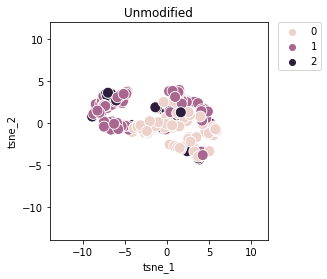

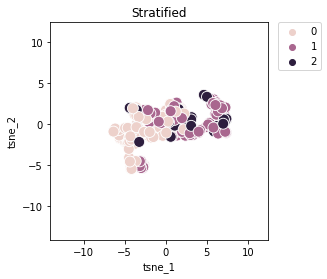

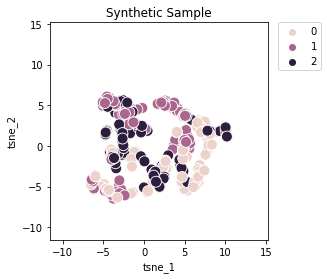

In [ ]:
#Notice that the Synth and reduced feature complexity has more seperation,
#still skeptical about the high score given there isn't clear seperation
#between the clases

df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=False,filter_cols=top20features)
tsne_plot(x_train,y_train,"Unmodified")
df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=True,filter_cols=top20features)
tsne_plot(x_train,y_train,"Stratified")
df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,synth_sample=True,filter_cols=top20features)
tsne_plot(x_train,y_train,"Synthetic Sample")

# Grid CV search to find best HP for each model below

In [ ]:
models = [DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]

df_results = pd.DataFrame()

stratify = [None,True,True,False,False]
fc = [None,None,top20features,top20features,top20features]
synth = [False,False,False,True,True]

for stratify,fc,synth in zip(stratify,fc,synth):
    for ntp in [5]:

        for tw in [7,14,21]:

            print("Section",ntp,tw)

            df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1,ntp, tw,stratify_sample=stratify,filter_cols=fc,synth_sample=synth)
                            
            for model in models:
                model_name = type(model).__name__
                clf = GridSearchCV(
                        estimator=model,
                        param_grid=classifier_params[type(model).__name__],
                        cv=3,
                        scoring="recall_micro",
                        return_train_score=True
                )
                
                clf_train = clf.fit(x_train, y_train)
                train_preds = clf.predict(x_train)
                test_preds = clf.predict(x_test)
                # plot_confusion_matrix(y_train, train_preds),plot_confusion_matrix(y_test, test_preds)

            


                df_model = pd.DataFrame(clf.cv_results_)
                df_model["Model"] = model_name
                df_model["ntp_tw"] = "-".join([str(ntp),str(tw)])
                df_model["dataset"] = str([stratify,fc,synth])
                
                df_results = pd.concat([df_results,df_model])

df_results.to_csv("model_results.csv")

Section 5 7


348it [00:00, 581.48it/s]


Section 5 14


348it [00:00, 599.15it/s]


Section 5 21


348it [00:00, 612.40it/s]


Section 5 7


348it [00:00, 587.19it/s]


Section 5 14


348it [00:00, 609.30it/s]


Section 5 21


348it [00:00, 629.22it/s]


Section 5 7


348it [00:00, 598.11it/s]


Section 5 14


348it [00:00, 618.45it/s]


Section 5 21


348it [00:00, 621.92it/s]


Section 5 7


348it [00:00, 606.61it/s]


Section 5 14


348it [00:00, 601.73it/s]


Section 5 21


348it [00:00, 621.12it/s]


Section 5 7


348it [00:00, 597.55it/s]


Section 5 14


348it [00:00, 613.79it/s]


Section 5 21


348it [00:00, 624.79it/s]


## Metrics

## All

In [ ]:
df_results["train_test"] = df_results["mean_train_score"] - df_results["mean_test_score"]
df_results = df_results.rename(columns={"ntp-tw":"ntp_tw"})

## NTP-TW 5-7

In [ ]:
(df_results[["Model","mean_train_score","mean_test_score","params","train_test","ntp_tw","dataset"]]
 .query('ntp_tw == "5-7"')
 .sort_values(["train_test","mean_test_score"],ascending=True)
 ).head(15)

,Model,mean_train_score,mean_test_score,params,train_test,ntp_tw,dataset
105,RandomForestClassifier,0.776883,0.734082,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 100, 'random_state': 42}",0.042801,5-7,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
103,RandomForestClassifier,0.770571,0.727763,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 80, 'random_state': 42}",0.042808,5-7,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
96,RandomForestClassifier,0.778001,0.735123,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 10, 'random_state': 42}",0.042878,5-7,"[None, None, False]"
0,AdaBoostClassifier,0.766786,0.720058,"{'n_estimators': 30, 'random_state': 42}",0.046728,5-7,"[None, None, False]"
28,RandomForestClassifier,0.798506,0.750187,"{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50, 'random_state': 42}",0.048319,5-7,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
106,RandomForestClassifier,0.773723,0.724588,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 110, 'random_state': 42}",0.049135,5-7,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
104,RandomForestClassifier,0.773723,0.721444,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 90, 'random_state': 42}",0.052279,5-7,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
102,RandomForestClassifier,0.770578,0.718299,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 70, 'random_state': 42}",0.052280,5-7,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
217,RandomForestClassifier,0.785429,0.731502,"{'max_depth': 6, 'min_samples_leaf': 12, 'n_estimators': 20, 'random_state': 42}",0.053927,5-7,"[None, None, False]"
337,RandomForestClassifier,0.785429,0.731502,"{'max_depth': 9, 'min_samples_leaf': 12, 'n_estimators': 20, 'random_state': 42}",0.053927,5-7,"[None, None, False]"


## NTP-TW 5-14

In [ ]:
(df_results[["Model","mean_train_score","mean_test_score","params","train_test","ntp_tw","dataset"]]
 .query('ntp_tw == "5-14"')
 .sort_values(["train_test","mean_test_score"],ascending=True)
 ).head(15)

,Model,mean_train_score,mean_test_score,params,train_test,ntp_tw,dataset
49,RandomForestClassifier,0.841587,0.828326,"{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 20, 'random_state': 42}",0.013261,5-14,"[None, None, False]"
25,RandomForestClassifier,0.860701,0.835989,"{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 20, 'random_state': 42}",0.024711,5-14,"[None, None, False]"
49,RandomForestClassifier,0.818686,0.790056,"{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 20, 'random_state': 42}",0.028631,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
24,RandomForestClassifier,0.843525,0.813088,"{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 10, 'random_state': 42}",0.030437,5-14,"[None, None, False]"
191,RandomForestClassifier,0.900722,0.870254,"{'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 240, 'random_state': 42}",0.030468,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
311,RandomForestClassifier,0.900722,0.870254,"{'max_depth': 9, 'min_samples_leaf': 6, 'n_estimators': 240, 'random_state': 42}",0.030468,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
431,RandomForestClassifier,0.900722,0.870254,"{'max_depth': 12, 'min_samples_leaf': 6, 'n_estimators': 240, 'random_state': 42}",0.030468,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
188,RandomForestClassifier,0.900733,0.870254,"{'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 210, 'random_state': 42}",0.030479,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
308,RandomForestClassifier,0.902638,0.870254,"{'max_depth': 9, 'min_samples_leaf': 6, 'n_estimators': 210, 'random_state': 42}",0.032384,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"
428,RandomForestClassifier,0.902638,0.870254,"{'max_depth': 12, 'min_samples_leaf': 6, 'n_estimators': 210, 'random_state': 42}",0.032384,5-14,"[True, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], False]"


## NTP-TW 5-21

In [ ]:
(df_results[["Model","mean_train_score","mean_test_score","params","train_test","ntp_tw","dataset"]]
 .query('ntp_tw == "5-21"')
 .sort_values(["train_test","mean_test_score"],ascending=True)
 ).head(15)

,Model,mean_train_score,mean_test_score,params,train_test,ntp_tw,dataset
24,RandomForestClassifier,0.891743,0.890387,"{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 10, 'random_state': 42}",0.001356,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
88,RandomForestClassifier,0.875679,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 170, 'random_state': 42}",0.003958,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
81,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
82,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 110, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
83,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 120, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
84,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 130, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
86,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 150, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
87,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 160, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
89,RandomForestClassifier,0.877017,0.871720,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_estimators': 180, 'random_state': 42}",0.005297,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"
97,RandomForestClassifier,0.871585,0.866120,"{'max_depth': 3, 'min_samples_leaf': 12, 'n_estimators': 20, 'random_state': 42}",0.005464,5-21,"[False, [68, 69, 36, 53, 21, 20, 52, 5, 14, 4, 26, 15, 6, 58, 22, 47, 37, 19, 25, 38], True]"


In [ ]:
# dtreeviz(clf, 
#          X_train, 
#          y_train,
#          target_name="target",
#          feature_names=to.cont_names,
#          class_names=['DAI', 'USDC', 'USDT'],)

In [ ]:
assert 1 == 0

AssertionError: ignored

## Save Models

In [ ]:
def save_models(ss,le,model,model_name,ntp,tw):
    save_pickle(path/f'Classification/sklearn/ss_{ntp}_{tw}.pkl', ss)
    save_pickle(path/f'Classification/sklearn/le_{ntp}_{tw}.pkl', le)
    save_pickle(path/f'Classification/sklearn/{model_name}_{ntp}_{tw}.pkl', model)

def load_predict(ss,le,rfc):
    df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7)
    x_train = ss.transform(x_train)
    x_test = ss.transform(x_test)

    train_preds = rfc.predict(x_train)
    train_preds = le.inverse_transform(train_preds)
    test_preds = rfc.predict(x_test)
    test_preds = le.inverse_transform(test_preds)
    y_train = le.inverse_transform(y_train)
    y_test = le.inverse_transform(y_test)

    plot_confusion_matrix(y_train, train_preds),plot_confusion_matrix(y_test, test_preds)



In [ ]:
df, x_train, x_test, y_train, y_test, ss, le  = get_tabpandas_multi(df1, 5, 7,stratify_sample=True)

a,b = np.unique(y_train,return_counts=True)
c,d = np.unique(y_test,return_counts=True)


In [ ]:
a,b

In [ ]:
c,d

In [ ]:
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60, random_state=42)

test_df = get_tabpandas_multi(df1, 5, 7,inference=True).sample(100)

train_size = 0.80
L = int(len(test_df)*train_size)

x_test = test_df.iloc[L:, :-4]
y_test = test_df.iloc[L:, -4]


ss = load_pickle(path/'Classification/sklearn/ss_5_7.pkl')
le = load_pickle(path/'Classification/sklearn/le_5_7.pkl')
rfc = load_pickle(path/'Classification/sklearn/RandomForestClassifier_5_7.pkl')


x_test = ss.transform(x_test)
preds = rfc.predict(x_test)
preds = le.inverse_transform(preds)


print(recall_score(y_test,preds,average="micro"))

plot_confusion_matrix(y_test, preds)

save_models(ss,le,clf,type(clf).__name__ +,5,7)

In [ ]:
preds

In [ ]:
assert 1 == 0

## Random Forest

In [ ]:
for i in range(30,151, 10):
    clf = RandomForestClassifier(n_estimators=i,random_state=RANDOM_STATE)
    clf = clf.fit(x_train, y_train)
    train_preds = clf.predict(x_train)
    test_preds = clf.predict(x_test)
    print(f"n_estimators: {i}")
    plot_confusion_matrix(y_train, train_preds),plot_confusion_matrix(y_test, test_preds)
    save_pickle('rfc_5_7.pkl', clf)

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

clf = RandomForestClassifier(n_estimators=60)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

fi = rf_feat_importance(clf, X_train)
fi[:20]

In [ ]:
top20features = list(fi[:20].cols)

In [ ]:
X_train_sel = x_train[top20features]
X_valid_sel = x_test[top20features]

In [ ]:
clf = RandomForestClassifier(n_estimators=60)
clf = clf.fit(X_train_sel, y_train)
train_preds = clf.predict(X_train_sel)
test_preds = clf.predict(X_valid_sel)

save_pickle('rfc_ft20_5_7.pkl', clf)

In [ ]:
plot_confusion_matrix(y_train, train_preds),plot_confusion_matrix(y_test, test_preds)

In [ ]:
bottom20features = list(fi[-20:].cols)
X_train_unsel = x_train[bottom20features]
X_valid_unsel = x_test[bottom20features]

clf = RandomForestClassifier(n_estimators=60)
clf = clf.fit(X_train_unsel, y_train)

train_preds = clf.predict(X_train_unsel)
test_preds = clf.predict(X_valid_unsel)

plot_confusion_matrix(y_train, train_preds),plot_confusion_matrix(y_test, test_preds)

In [ ]:
clf = AdaBoostClassifier(n_estimators=60)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

plot_confusion_matrix(y_valid, preds)

In [ ]:
#best so far??
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=0.1)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

plot_confusion_matrix(y_valid, preds)

## target_window = 14

In [ ]:
df, to, dls = get_tabpandas_multi(df1, 14, 5)

In [ ]:
X_train = to.train.xs
y_train = to.train.y
X_valid = to.valid.xs
y_valid = to.valid.y

In [ ]:
y_train.value_counts()

In [ ]:
y_valid.value_counts()

In [ ]:
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=0.1)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

plot_confusion_matrix(y_valid, preds)

In [ ]:
clf = RandomForestClassifier(n_estimators=60)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

plot_confusion_matrix(y_valid, preds)

## target_window = 21

In [ ]:
df, to, dls = get_tabpandas_multi(df1, 21, 5)
X_train = to.train.xs
y_train = to.train.y
X_valid = to.valid.xs
y_valid = to.valid.y

In [ ]:
y_train.value_counts()

In [ ]:
y_valid.value_counts()

In [ ]:
clf = GradientBoostingClassifier(n_estimators=60, 
                                 learning_rate=0.1)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

plot_confusion_matrix(y_valid, preds)

In [ ]:
clf = RandomForestClassifier(n_estimators=60)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

plot_confusion_matrix(y_valid, preds)